In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

os.environ['XILINX_VITIS'] = '/tools/Xilinx/Vitis/2024.2'
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2024.2/bin:' + os.environ['PATH']


models_path = 'models'
history_path = 'history'
project_folder = 'Projects'

# Params
n_classes = 10
train = False
n_epochs = 15

2025-08-08 19:09:35.376527: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 19:09:35.378153: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 19:09:35.400199: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 19:09:35.400215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 19:09:35.400238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

def doWeights(model, title=None, only_pruned=True, show_layer_types=True):
    """
    Visualizes the Gaussian KDE (smoothed histogram) of weight distributions for each layer.

    Args:
        model (tf.keras.Model): The model to analyze.
        title (str): Optional plot title.
        only_pruned (bool): Whether to include only pruned layers in the plot.
        show_layer_types (bool): Annotate each layer with its class name.
    """
    layer_weights_dict = {}

    for layer in model.layers:
        if not layer.weights:
            continue
        if 'batch' in layer.name.lower():  # Skip batchnorm
            continue

        weights = []
        for w in layer.weights:
            try:
                weights.extend(w.numpy().flatten())
            except:
                continue

        if len(weights) == 0:
            continue

        weights = np.array(weights)
        if only_pruned and 'prune' not in layer.name.lower():
            continue

        label = f"{layer.name} ({type(layer).__name__})" if show_layer_types else layer.name
        layer_weights_dict[label] = weights

    if not layer_weights_dict:
        print("⚠️ No valid layers found for plotting.")
        return

    # KDE Plot
    plt.figure(figsize=(14, 6))
    for label, weights in layer_weights_dict.items():
        sns.kdeplot(weights, label=label, linewidth=1.5, fill=True, alpha=0.2)

    plt.title(title or f"Weight Distribution (KDE) for Model: {model.name}", fontsize=14)
    plt.xlabel("Weight Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='upper right', fontsize='small', title='Layers')
    plt.tight_layout()
    plt.show()


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

def extract_layer_weights(model, clip_range):
    result = {}

    for layer in model.layers:

        # Handle PruneLowMagnitude wrapped layers
        if hasattr(layer, "layer"):
            base_layer = layer.layer
            layer_name = layer.name.replace("prune_low_magnitude_", "")
        else:
            base_layer = layer
            layer_name = layer.name


        # Handle QConv2DBatchnorm (e.g., fused_convbn_X)
        if isinstance(base_layer, QConv2DBatchnorm):
            conv_weights, bn_weights = [], []

            for sublayer in base_layer.submodules:
                if isinstance(sublayer, tf.keras.layers.Conv2D):
                    conv_weights.extend(sublayer.get_weights())
                elif isinstance(sublayer, tf.keras.layers.BatchNormalization):
                    bn_weights.extend(sublayer.get_weights())

            if conv_weights:
                result[f"{layer_name}_conv"] = {
                    "weights": np.clip(np.concatenate([w.flatten() for w in conv_weights]), *clip_range),
                    "type": "QConv2D"
                }
            if bn_weights:
                result[f"{layer_name}_bn"] = {
                    "weights": np.clip(np.concatenate([w.flatten() for w in bn_weights]), *clip_range),
                    "type": "BatchNormalization"
                }

        # Handle QDense
        elif isinstance(base_layer, QDense):
            weights = base_layer.get_weights()
            if weights:
                weights_flat = np.concatenate([w.flatten() for w in weights])
                result[layer_name] = {
                    "weights": np.clip(weights_flat, *clip_range),
                    "type": "QDense"
                }

        # Handle standard Dense (e.g., output layer)
        elif isinstance(base_layer, tf.keras.layers.Dense):
            weights = base_layer.get_weights()
            if weights:
                weights_flat = np.concatenate([w.flatten() for w in weights])
                result[layer_name] = {
                    "weights": np.clip(weights_flat, *clip_range),
                    "type": "Dense"
                }

        # Fallback
        elif hasattr(base_layer, 'get_weights'):
            weights = base_layer.get_weights()
            if weights:
                weights_flat = np.concatenate([w.flatten() for w in weights])
                result[layer_name] = {
                    "weights": np.clip(weights_flat, *clip_range),
                    "type": type(base_layer).__name__
                }

    return result

def compareWeightDistributions(
    model_a, model_b,
    label_a="Original",
    label_b="Pruned",
    clip_range=(-10, 10),
    group_by_layer_type=True,
    only_shared_layers=False
):
    weights_a = extract_layer_weights(model_a, clip_range)
    weights_b = extract_layer_weights(model_b, clip_range)

    if only_shared_layers:
        keys = sorted(set(weights_a.keys()) & set(weights_b.keys()))
    else:
        keys = sorted(set(weights_a.keys()) | set(weights_b.keys()))

    # Filter to only layers that exist in both and have weights in both
    valid_keys = []
    for k in keys:
        if k in weights_a and k in weights_b:
            if len(weights_a[k]["weights"]) > 0 and len(weights_b[k]["weights"]) > 0:
                valid_keys.append(k)

    if not valid_keys:
        print("⚠️ No valid layers to compare.")
        return

    # Plotting layout
    ncols = 3
    nrows = int(np.ceil(len(valid_keys) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 3))
    axes = axes.flatten()

    for idx, layer_name in enumerate(valid_keys):
        ax = axes[idx]
        wa = weights_a[layer_name]["weights"]
        wb = weights_b[layer_name]["weights"]
        lt = weights_a[layer_name]["type"]

        sns.kdeplot(wa, ax=ax, label=label_a, lw=2)
        sns.kdeplot(wb, ax=ax, label=label_b, lw=2, linestyle="--")

        ax.set_title(f"{layer_name}\n({lt})", fontsize=10)
        ax.set_xlabel("Weight Value")
        ax.set_ylabel("Density")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(fontsize=8)

    # Hide unused subplots
    for j in range(len(valid_keys), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    fig.suptitle("Weight Distribution Comparison Per Layer", fontsize=16, y=1.02)
    plt.show()



In [4]:
import math
from collections import defaultdict

def reuse_percentage_to_factors(model, serial_pct: float = 1.0):
    """
    Map each Dense / Conv / DepthwiseConv layer to a valid hls4ml ReuseFactor.

    Parameters
    ----------
    model       : Keras / QKeras model
    serial_pct  : float in [0, 1]
        1.0 → completely serial (largest legal reuse factor)
        0.0 → completely parallel (ReuseFactor = 1)

    Returns
    -------
    dict {layer_name: reuse_factor}
    """
    from tensorflow.keras.layers import Dense, Conv2D, DepthwiseConv2D
    from qkeras import QDense, QConv2D, QDepthwiseConv2D

    if not 0.0 <= serial_pct <= 1.0:
        raise ValueError("serial_pct must be in [0, 1]")

    reuse = {}

    
    def legal_divisor(n, candidate):
        """Decrease candidate until it cleanly divides n."""
        while candidate > 1 and n % candidate:
            candidate -= 1
        return max(1, candidate)
    

    for layer in model.layers:
        if isinstance(layer, (Dense, QDense)):
            total = layer.input_shape[-1] * layer.units          # Nin × Nout

        elif isinstance(layer, (Conv2D, QConv2D)):
            kh, kw   = layer.kernel_size
            cin      = layer.input_shape[-1]
            cout     = layer.filters
            total    = kh * kw * cin * cout                      # per-pixel MACs

        elif isinstance(layer, (DepthwiseConv2D, QDepthwiseConv2D)):
            kh, kw   = layer.kernel_size
            cin      = layer.input_shape[-1]
            total    = kh * kw * cin                             # per-pixel MACs

        else:
            continue  # no MACs → nothing to tune

        #   serial_pct = 1.0  → target_rf = total  (most serial)
        #   serial_pct = 0.0  → target_rf = 1      (fully parallel)
        target_rf = int(round(total * serial_pct))
        target_rf = min(max(1, target_rf), total)

        # Snap downward to the nearest divisor so that total % rf == 0
        rf = legal_divisor(total, target_rf)

        reuse[layer.name] = rf
        print(f"{layer.name:20s}  MACs={total:6d}  ReuseFactor={rf}")

    return reuse


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Reshape to add channel dimension (28x28x1)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test  = x_test.reshape((-1, 28, 28, 1))

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# Split off a validation set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create tf.data.Dataset objects (optional but recommended for performance)
batch_size = 1024

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
val_data   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_data  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

train_size = len(x_train) 

input_shape = (28, 28, 1)
n_classes = 10

In [6]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))


# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

Number of training steps per epoch is 47


In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

filters_per_conv_layer = [8, 16]
neurons_per_dense_layer = [48, 24]
    

def build_cnn(filter=filters_per_conv_layer, neurons=neurons_per_dense_layer, input=input_shape):
    x = x_in = Input(input)
    for i, f in enumerate(filters_per_conv_layer):
        print(('Adding convolutional block {} with N={} filters').format(i, f))
        x = Conv2D(
            int(f),
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
            use_bias=False,
            name='conv_{}'.format(i),
        )(x)
        x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
        x = Activation('relu', name='conv_act_%i' % i)(x)
        x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
    x = Flatten()(x)

    for i, n in enumerate(neurons_per_dense_layer):
        print(('Adding dense block {} with N={} neurons').format(i, n))
        x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
        x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
        x = Activation('relu', name='dense_act_%i' % i)(x)
    x = Dense(int(n_classes), name='output_dense')(x)
    x_out = Activation('softmax', name='output_softmax')(x)

    model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')
    model.summary()
    
    return model


In [9]:
model = build_cnn()

Adding convolutional block 0 with N=8 filters
Adding convolutional block 1 with N=16 filters
Adding dense block 0 with N=48 neurons
Adding dense block 1 with N=24 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 26, 26, 8)         72        
                                                                 
 bn_conv_0 (BatchNormalizat  (None, 26, 26, 8)         32        
 ion)                                                            
                                                                 
 conv_act_0 (Activation)     (None, 26, 26, 8)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 8)         0         
             

In [10]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv_0: 72
conv_1: 1152
dense_0: 19200
Layer dense_0 is too large (19200), are you sure you want to train?
dense_1: 1152
output_dense: 240


In [11]:
save_path_baseline = os.path.join(models_path, 'cnn_model.h5')

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ]

    start = time.time()
    history_baseline = model.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))
    model.save(save_path_baseline)


else:
    model = tf.keras.models.load_model(save_path_baseline)

In [13]:
if train:
    from utils.nn_utils import plot_history, save_history
    plot_history(history_baseline.history, metrics=['loss', 'val_loss'], ylabel='Loss')
    plot_history(history_baseline.history, metrics=['accuracy', 'val_accuracy'], ylabel='Accuracy')
    save_history(history_baseline.history, f'{history_path}/baseline_cnn.history')

In [14]:
model = build_cnn()

model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Adding convolutional block 0 with N=8 filters
Adding convolutional block 1 with N=16 filters
Adding dense block 0 with N=48 neurons
Adding dense block 1 with N=24 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 26, 26, 8)         72        
                                                                 
 bn_conv_0 (BatchNormalizat  (None, 26, 26, 8)         32        
 ion)                                                            
                                                                 
 conv_act_0 (Activation)     (None, 26, 26, 8)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 8)         0         
             

In [15]:
save_path = os.path.join(models_path, 'pruned_cnn_model.h5')

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = model_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))
    model_pruned.save(save_path)


else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model(f'{models_path}/pruned_cnn_model.h5', custom_objects=co)

In [16]:
if train:
    from utils.nn_utils import plot_history, save_history
    plot_history(history.history, metrics=['loss', 'val_loss'], ylabel='Loss')
    plot_history(history.history, metrics=['accuracy', 'val_accuracy'], ylabel='Accuracy')
    save_history(history.history, f'{history_path}/baseline_cnn_pruned.history')

In [17]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm


def build_q_cnn(filter=filters_per_conv_layer, neurons=neurons_per_dense_layer, input=input_shape):
    x = x_in = Input(shape=input_shape)

    for i, f in enumerate(filters_per_conv_layer):
        print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
        x = QConv2DBatchnorm(
            int(f),
            kernel_size=(3, 3),
            strides=(1, 1),
            kernel_quantizer="quantized_bits(6,0,alpha=1)",
            bias_quantizer="quantized_bits(6,0,alpha=1)",
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
            use_bias=True,
            name='fused_convbn_{}'.format(i),
        )(x)
        x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
        x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
    x = Flatten()(x)

    for i, n in enumerate(neurons_per_dense_layer):
        print(('Adding QDense block {} with N={} neurons').format(i, n))
        x = QDense(
            n,
            kernel_quantizer="quantized_bits(6,0,alpha=1)",
            kernel_initializer='lecun_uniform',
            kernel_regularizer=l1(0.0001),
            name='dense_%i' % i,
            use_bias=False,
        )(x)
        x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
        x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
    x = Dense(int(n_classes), name='output_dense')(x)
    x_out = Activation('softmax', name='output_softmax')(x)
    qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

    qmodel.summary()
    
    return qmodel

In [18]:
qmodel = build_q_cnn()

Adding fused QConv+BN block 0 with N=8 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding QDense block 0 with N=48 neurons
Adding QDense block 1 with N=24 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 fused_convbn_0 (QConv2DBat  (None, 26, 26, 8)         113       
 chnorm)                                                         
                                                                 
 conv_act_0 (QActivation)    (None, 26, 26, 8)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 8)         0         
                                                                 
 fused_convbn_1 (QConv2DBat  (None, 11, 11, 16)        1233      
 chnorm)         

In [19]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)

fused_convbn_0       f=8 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_0           quantized_relu(6)
fused_convbn_1       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
dense_0              u=48 quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)
dense_1              u=24 quantized_bits(6,0,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(6)



In [20]:
q_save_path = os.path.join(models_path, 'quantized_cnn.h5')

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]

    start = time.time()
    history = qmodel.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel.save(q_save_path)

else:
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    qmodel = tf.keras.models.load_model(q_save_path, custom_objects=co)

In [21]:
if train:
    from utils.nn_utils import plot_history, save_history
    plot_history(history.history, metrics=['loss', 'val_loss'], ylabel='Loss')
    plot_history(history.history, metrics=['accuracy', 'val_accuracy'], ylabel='Accuracy')
    save_history(history.history, f'{history_path}/quantized_cnn.history')

In [ ]:
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
qmodel = build_q_cnn()

qmodel_pruned = tf.keras.models.clone_model(qmodel, clone_function=pruneFunction)

Adding fused QConv+BN block 0 with N=8 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding QDense block 0 with N=48 neurons
Adding QDense block 1 with N=24 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 fused_convbn_0 (QConv2DBat  (None, 26, 26, 8)         113       
 chnorm)                                                         
                                                                 
 conv_act_0 (QActivation)    (None, 26, 26, 8)         0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 8)         0         
                                                                 
 fused_convbn_1 (QConv2DBat  (None, 11, 11, 16)        1233      
 chnorm)         

In [23]:
q_save_path_prunned = os.path.join(models_path, 'quantized_pruned_cnn_model.h5')

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.8, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save(q_save_path_prunned)

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model(q_save_path_prunned, custom_objects=co)

In [24]:
if train:
    from utils.nn_utils import plot_history, save_history
    plot_history(history.history, metrics=['loss', 'val_loss'], ylabel='Loss')
    plot_history(history.history, metrics=['accuracy', 'val_accuracy'], ylabel='Accuracy')
    save_history(history.history, f'{history_path}/quantized_cnn_prunned.history')

In [25]:
predict_baseline = model_pruned.predict(x_test)
test_score_baseline = model_pruned.evaluate(x_test, y_test)

predict_qkeras = qmodel_pruned.predict(x_test)
test_score_qkeras = qmodel_pruned.evaluate(x_test, y_test)

print('Keras accuracy = {} , QKeras 6-bit accuracy = {}'.format(test_score_baseline[1], test_score_qkeras[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.1167 - accuracy: 0.9802
Keras accuracy = 0.9847999811172485 , QKeras 6-bit accuracy = 0.9801999926567078


Plotting ROC for labels ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


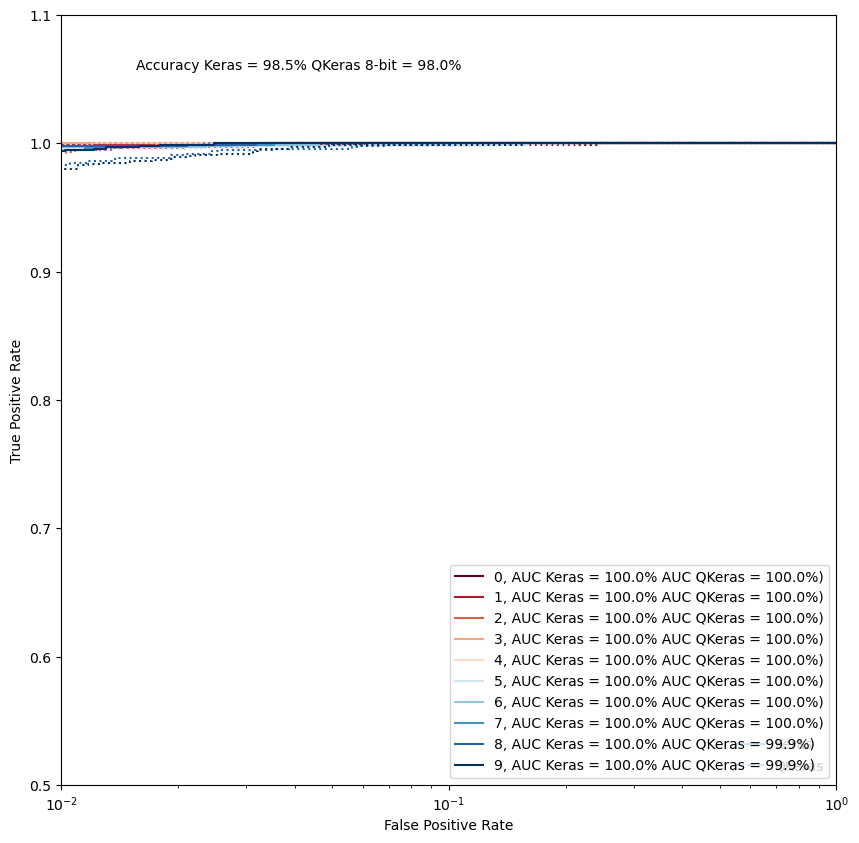

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


labels = ['%i' % nr for nr in range(0, n_classes)]  # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_q = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
fpr_q = {}
tpr_q = {}
auc1_q = {}
%matplotlib inline
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] = y_test[:, int(label)]
    df[label + '_pred'] = predict_baseline[:, int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label], df[label + '_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])

    df_q[label] = y_test[:, int(label)]
    df_q[label + '_pred'] = predict_qkeras[:, int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label], df_q[label + '_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])

    plt.plot(
        fpr[label],
        tpr[label],
        label=r'{}, AUC Keras = {:.1f}% AUC QKeras = {:.1f}%)'.format(label, auc1[label] * 100, auc1_q[label] * 100),
        linewidth=1.5,
        c=colors[i],
        linestyle='solid',
    )
    plt.plot(fpr_q[label], tpr_q[label], linewidth=1.5, c=colors[i], linestyle='dotted')

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01, 1.0)
plt.ylim(0.5, 1.1)
plt.legend(loc='lower right')
plt.figtext(
    0.2,
    0.83,
    r'Accuracy Keras = {:.1f}% QKeras 8-bit = {:.1f}%'.format(test_score_baseline[1] * 100, test_score_qkeras[1] * 100),
    wrap=True,
    horizontalalignment='left',
    verticalalignment='center',
)
from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['Keras', 'QKeras'], loc='lower right', frameon=False)
ax.add_artist(leg)

Model A layers: dict_keys(['conv_0', 'bn_conv_0', 'conv_1', 'bn_conv_1', 'dense_0', 'bn_dense_0', 'dense_1', 'bn_dense_1', 'output_dense'])
Model B layers: dict_keys(['conv_0', 'bn_conv_0', 'conv_1', 'bn_conv_1', 'dense_0', 'bn_dense_0', 'dense_1', 'bn_dense_1', 'output_dense'])


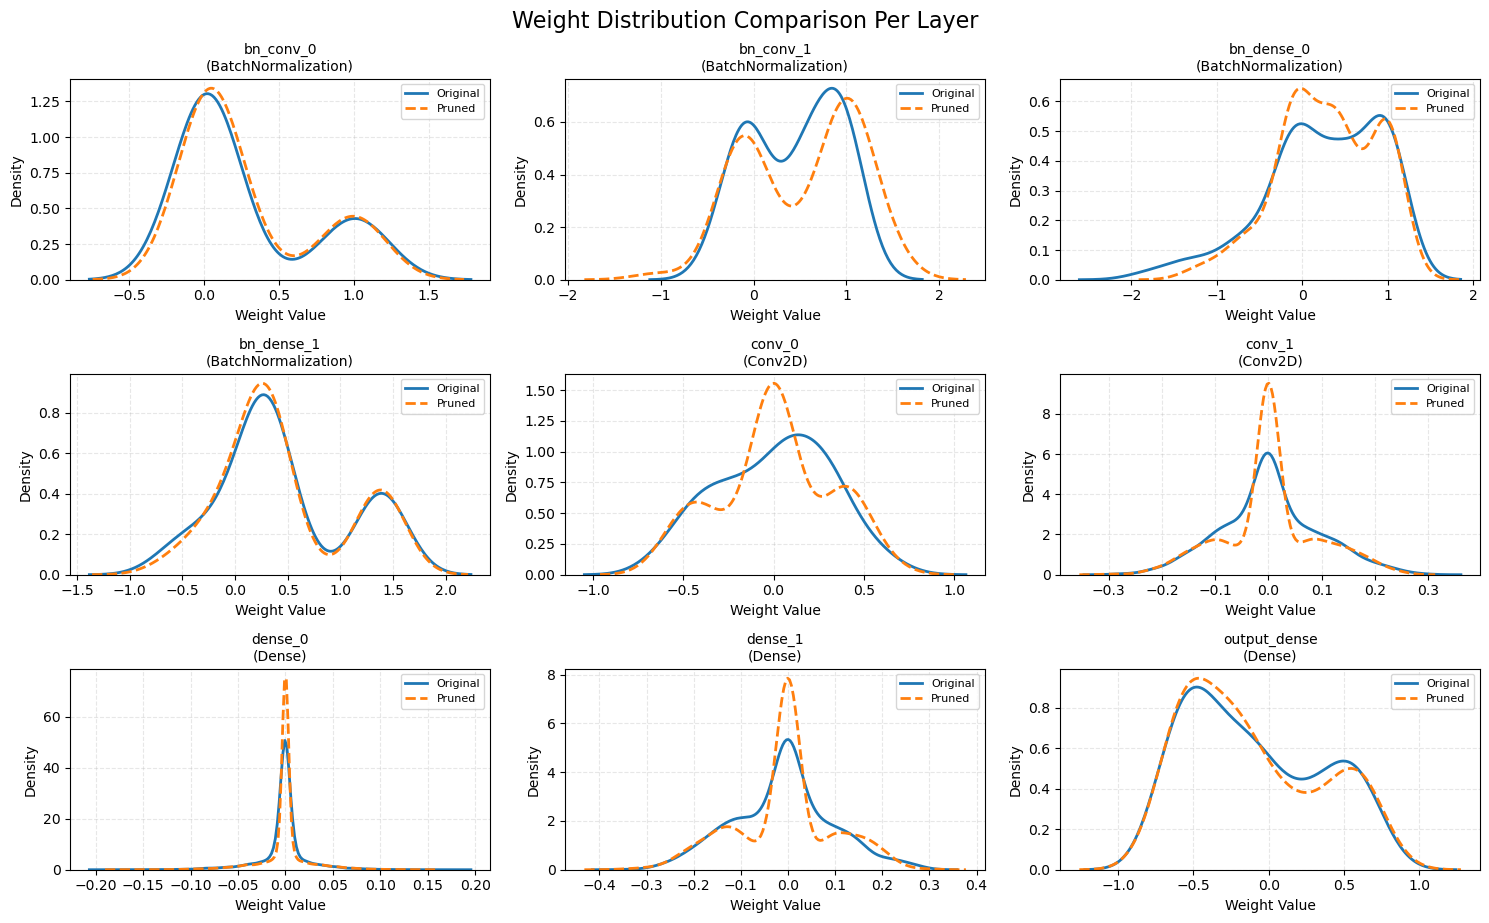

In [38]:
model_a=tf.keras.models.load_model(save_path_baseline)
from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

co = {}
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
model_b = tf.keras.models.load_model(save_path, custom_objects=co)
weights_a = extract_layer_weights(model_a, clip_range=(-5, 5))
weights_b = extract_layer_weights(model_b, clip_range=(-5, 5))

print("Model A layers:", weights_a.keys())
print("Model B layers:", weights_b.keys())

compareWeightDistributions(
    model_a=model_a,
    model_b=model_b,
    label_a="Original",
    label_b="Pruned",
    clip_range=(-5, 5),
    group_by_layer_type=True,
    only_shared_layers=True
)


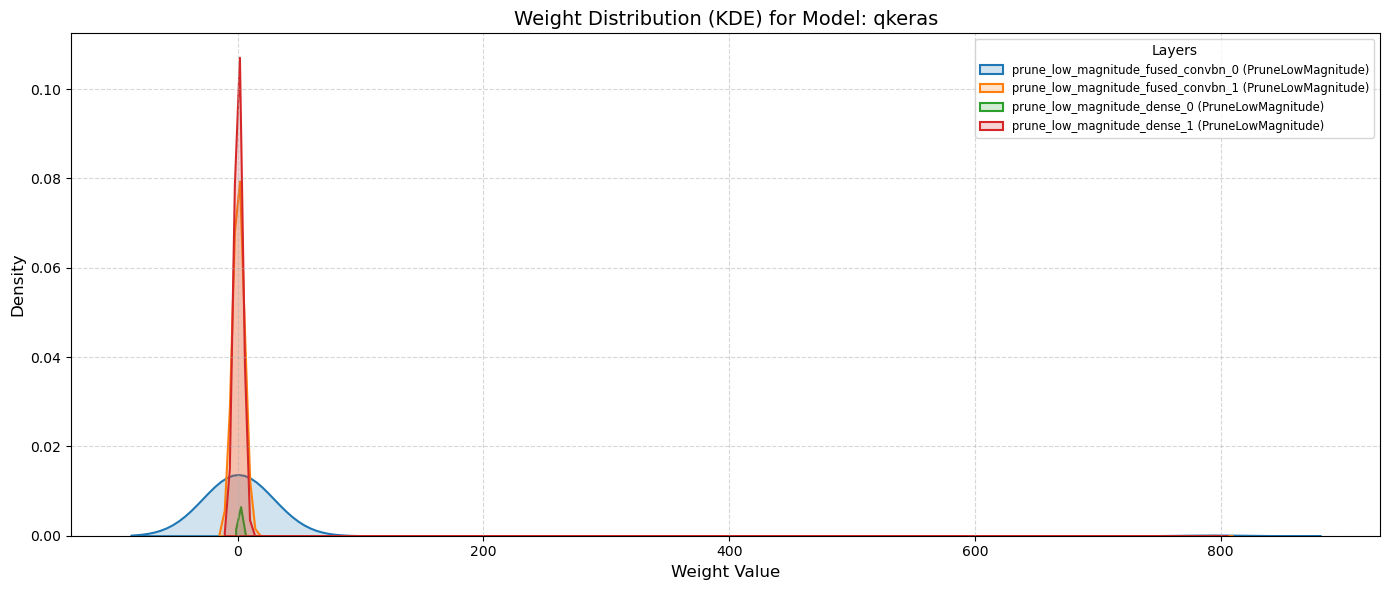

In [40]:
doWeights(model_b)

Model A layers: dict_keys(['fused_convbn_0_bn', 'fused_convbn_1_bn', 'dense_0', 'bn_dense_0', 'dense_1', 'bn_dense_1', 'output_dense'])
Model B layers: dict_keys(['fused_convbn_0_bn', 'fused_convbn_1_bn', 'dense_0', 'bn_dense_0', 'dense_1', 'bn_dense_1', 'output_dense'])


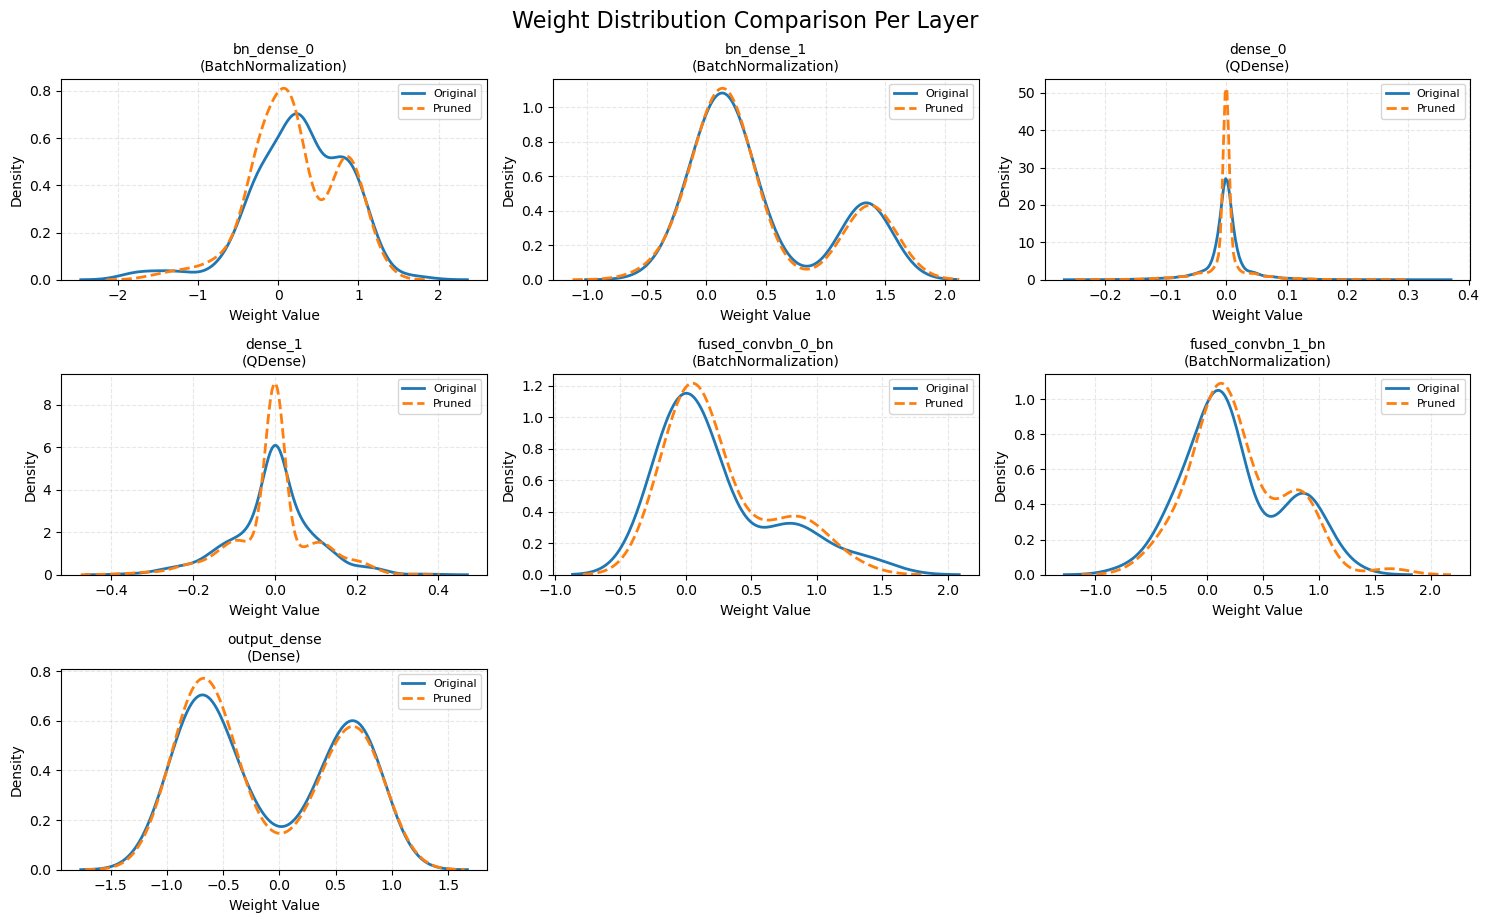

In [41]:
from qkeras.utils import _add_supported_quantized_objects
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

co = {}
_add_supported_quantized_objects(co)

model_a=tf.keras.models.load_model(q_save_path, custom_objects=co)
co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
model_b = tf.keras.models.load_model(q_save_path_prunned, custom_objects=co)
# After extraction
weights_a = extract_layer_weights(model_a, clip_range=(-5, 5))
weights_b = extract_layer_weights(model_b, clip_range=(-5, 5))

print("Model A layers:", weights_a.keys())
print("Model B layers:", weights_b.keys())


compareWeightDistributions(
    model_a=model_a,
    model_b=model_b,
    label_a="Original",
    label_b="Pruned",
    clip_range=(-5, 5),
    group_by_layer_type=True,
    only_shared_layers=False
)

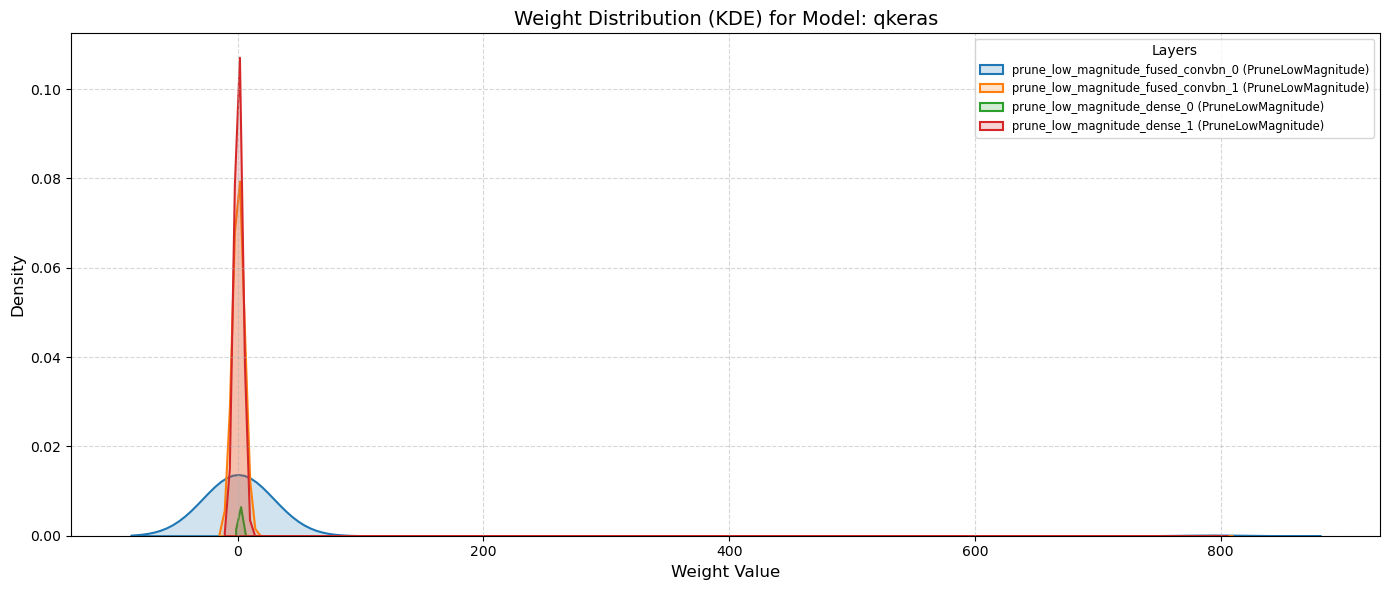

In [42]:
doWeights(model_b)

In [43]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model(q_save_path_prunned, custom_objects=co)
model = strip_pruning(model)

qmodel = tf.keras.models.load_model(q_save_path_prunned, custom_objects=co)
qmodel = strip_pruning(qmodel)

In [ ]:
import hls4ml
import utils.plotting as plotting

# Generate base HLS config
hls_config = hls4ml.utils.config_from_keras_model(
    model,
    granularity='name',
    backend='Vitis',
    default_precision='ap_fixed<16,6>'
)

# Set model-level precision
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'

# Force Resource strategy globally
for lname, lcfg in hls_config['LayerName'].items():
    lcfg['Strategy'] = 'Resource'

# Inject computed reuse factors
reuse_factors = reuse_percentage_to_factors(model, serial_pct=1.0)
for lname, factor in reuse_factors.items():
    if lname in hls_config['LayerName']:
        hls_config['LayerName'][lname]['ReuseFactor'] = factor
    else:
        print(f"Warning: Layer {lname} not found in HLS config")

plotting.print_dict(hls_config)

save_proj_path = os.path.join(project_folder, 'Baseline')

# Convert and compile
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=hls_config,
    backend='Vitis',
    output_dir=save_proj_path,
    part='xck26-sfvc784-2LV-c',
    io_type='io_stream',
    clock_period=5,
    trace=True,
    project_name='baseline_cnn', 
)
hls_model.compile()


/home/theodoros/miniconda3/envs/ai_on_fpga/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Model
Topology:
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten_3, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: dense_0, layer type: QDense, input

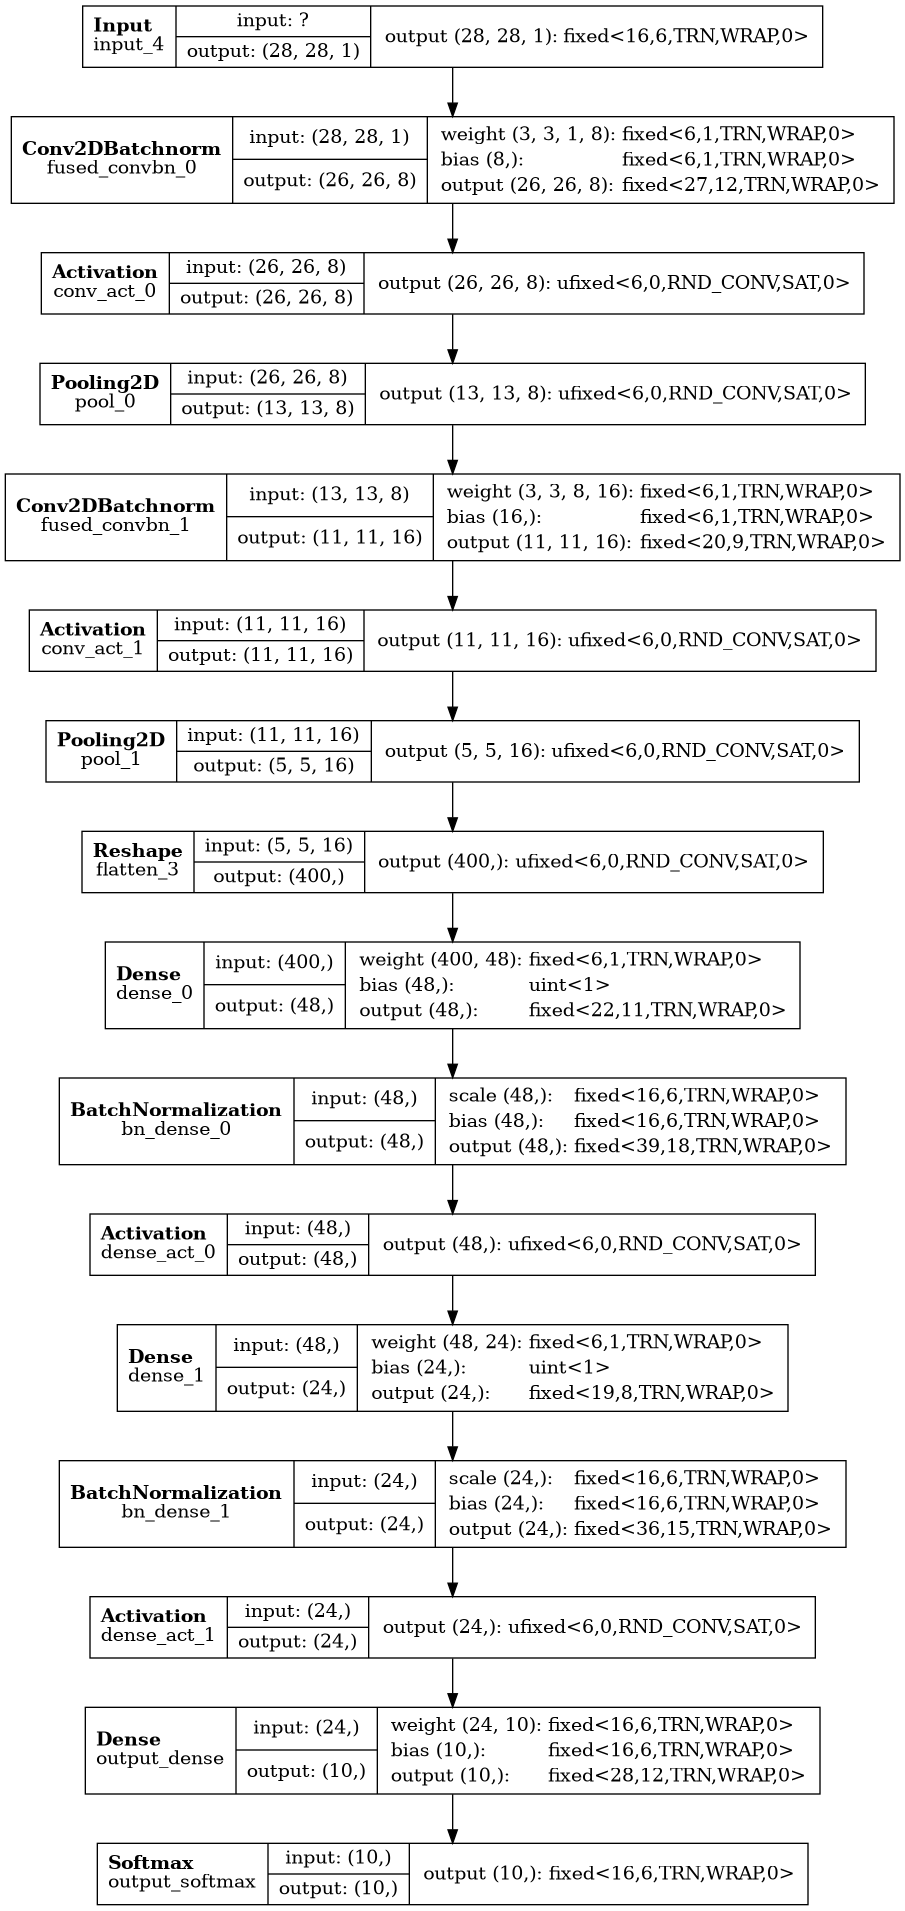

In [45]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten_3, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: dense_0, layer type: QDense, input

/home/theodoros/miniconda3/envs/ai_on_fpga/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

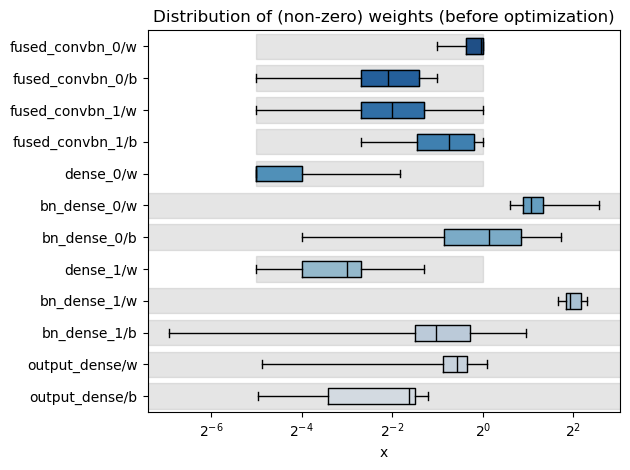

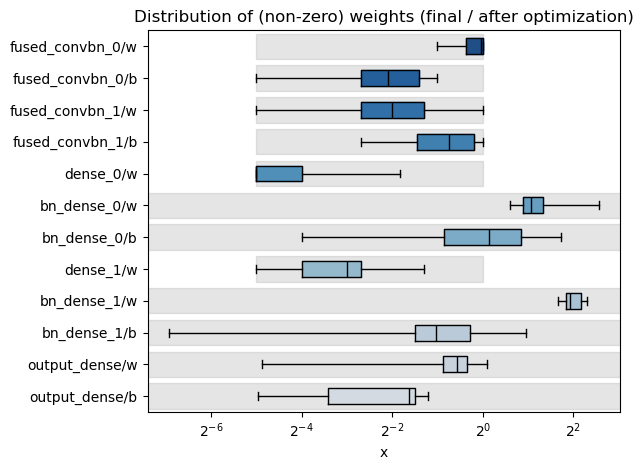

In [46]:
from hls4ml.model.profiling import numerical

numerical(model=model, hls_model=hls_model)

In [ ]:

# Generate config from QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(
    qmodel,
    granularity='name',
    backend='Vitis',
    default_precision='ap_fixed<16,6>'
)
# Set model-level precision
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'

# Force Resource strategy globally
for lname, lcfg in hls_config_q['LayerName'].items():
    lcfg['Strategy'] = 'Resource'

# Inject computed reuse factors
reuse_factors = reuse_percentage_to_factors(qmodel, serial_pct=1.0)
for lname, factor in reuse_factors.items():
    if lname in hls_config_q['LayerName']:
        hls_config_q['LayerName'][lname]['ReuseFactor'] = factor
    else:
        print(f"Warning: Layer {lname} not found in HLS config")
    

plotting.print_dict(hls_config_q)

save_proj_path = os.path.join(project_folder, 'Quantized')

# Convert and compile
hls_model_q = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=hls_config_q,
    output_dir=save_proj_path,
    backend='Vitis',
    io_type='io_stream',
    clock_period=5,
    trace=True,
    part = 'xck26-sfvc784-2LV-c',
    project_name="quantized_cnn"
)

hls_model_q.compile()


/home/theodoros/miniconda3/envs/ai_on_fpga/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Model
Topology:
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten_3, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: dense_0, layer type: QDense, input

Interpreting Model
Topology:
Layer name: input_4, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 8]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 8]], output shape: [None, 26, 26, 8]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 8]], output shape: [None, 13, 13, 8]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 8]], output shape: [None, 11, 11, 16]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten_3, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: dense_0, layer type: QDense, input

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

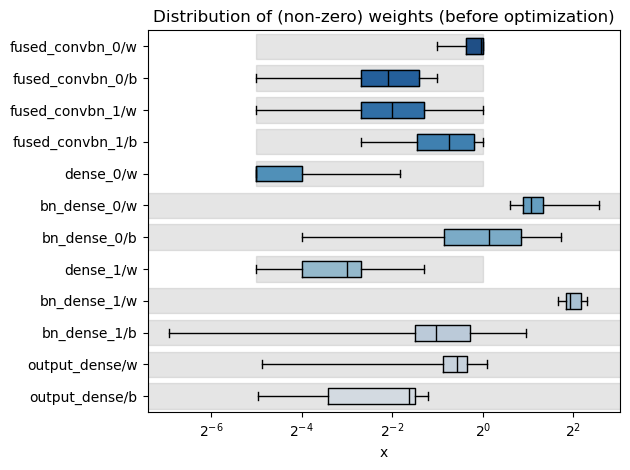

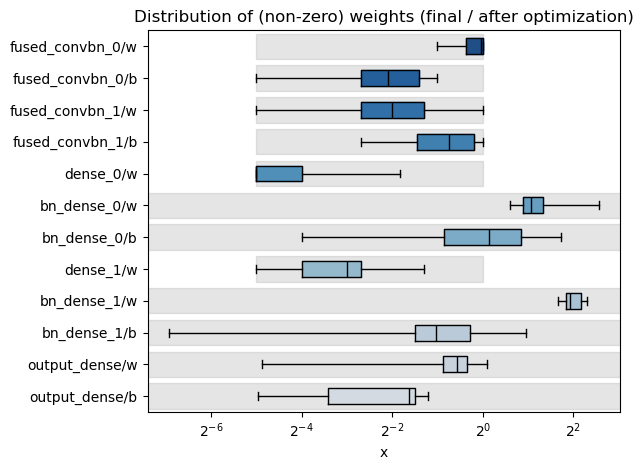

In [48]:
numerical(model=qmodel, hls_model=hls_model_q)

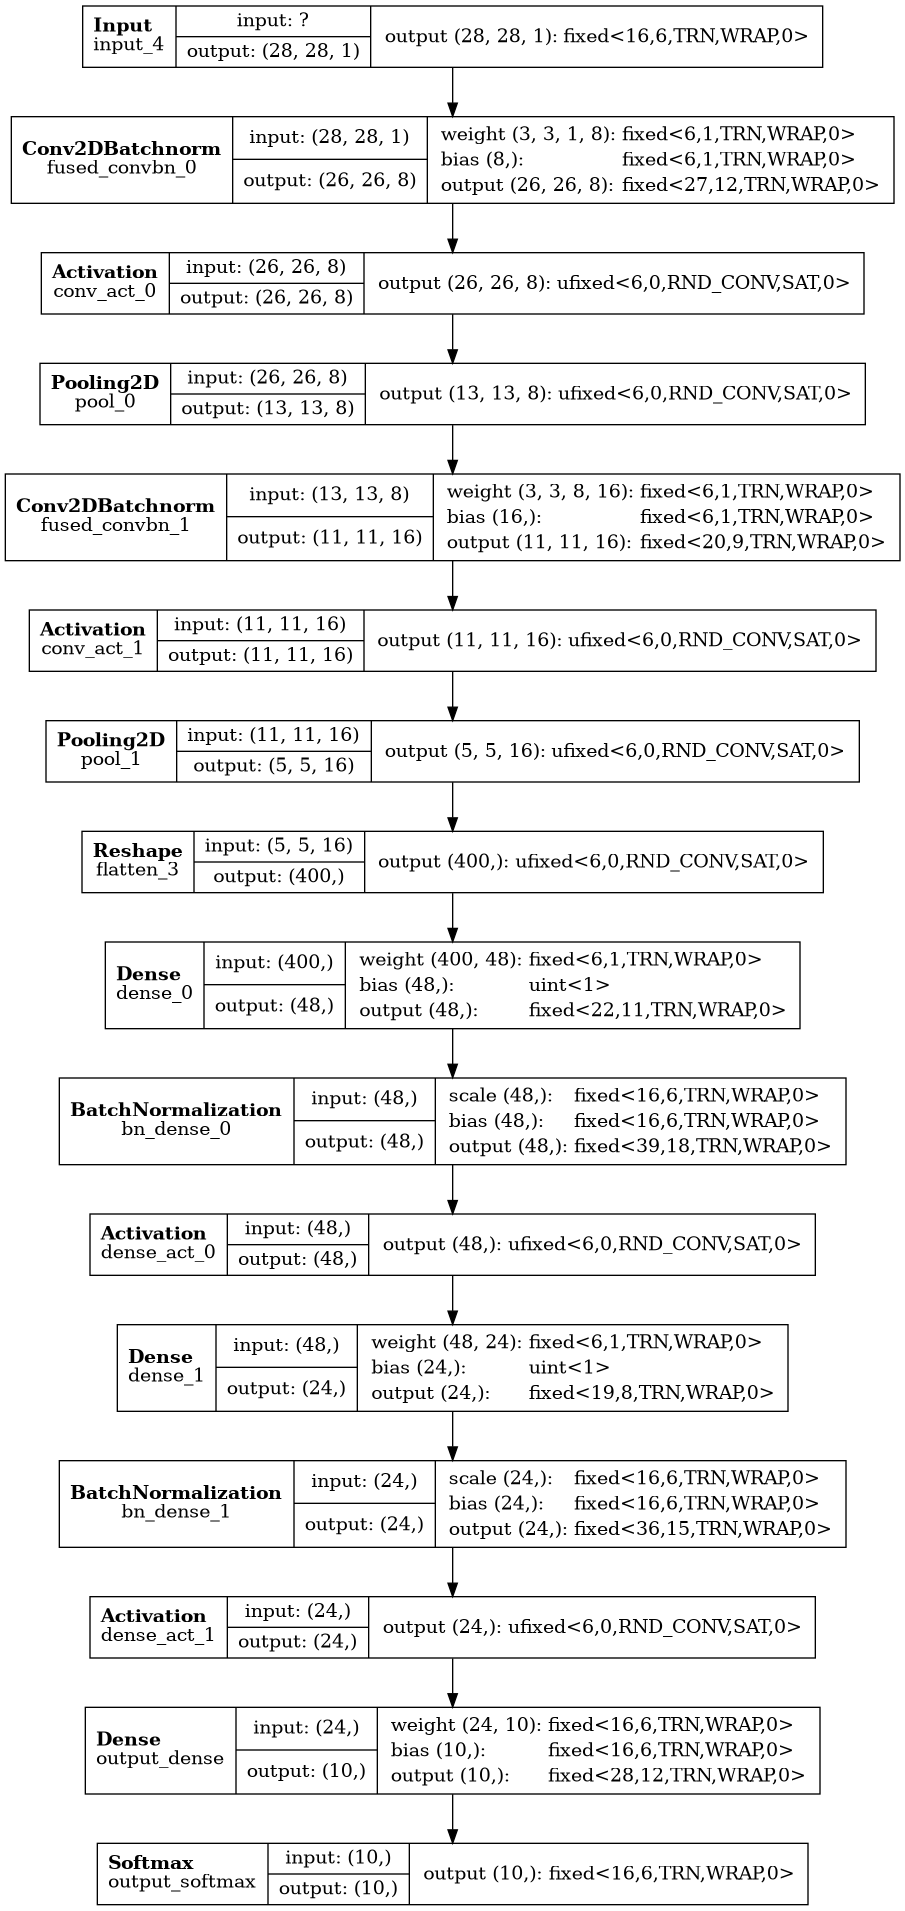

In [49]:
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

In [50]:
y_predict = model.predict(x_test)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 1s 2ms/step


In [51]:
y_predict_q = qmodel.predict(x_test)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 1s 2ms/step


Accuracy Keras:  0.9802
Accuracy hls4ml: 0.9805
Accuracy Keras:  0.9802
Accuracy hls4ml: 0.9805


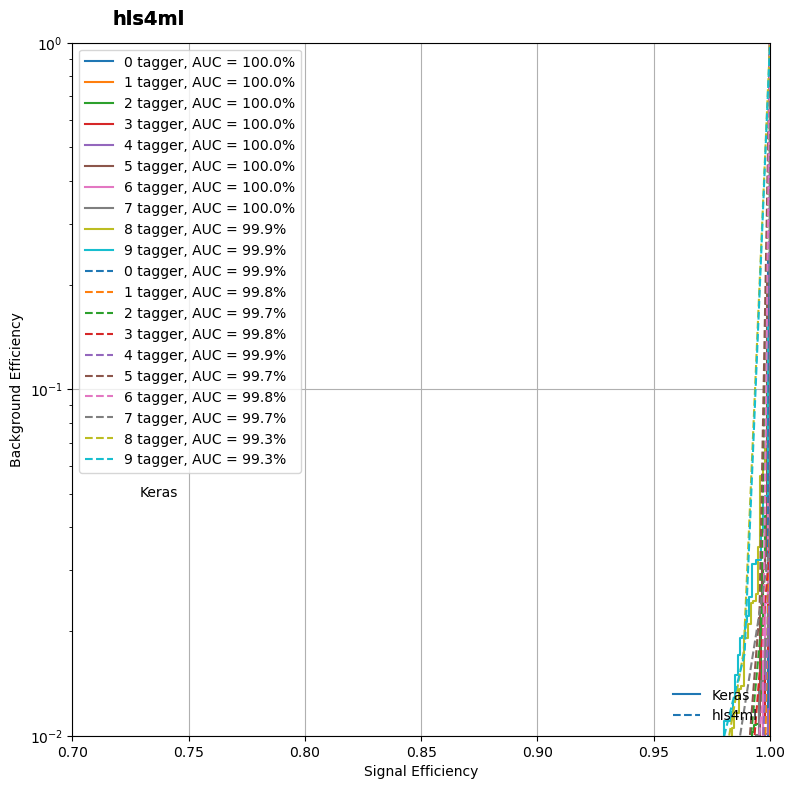

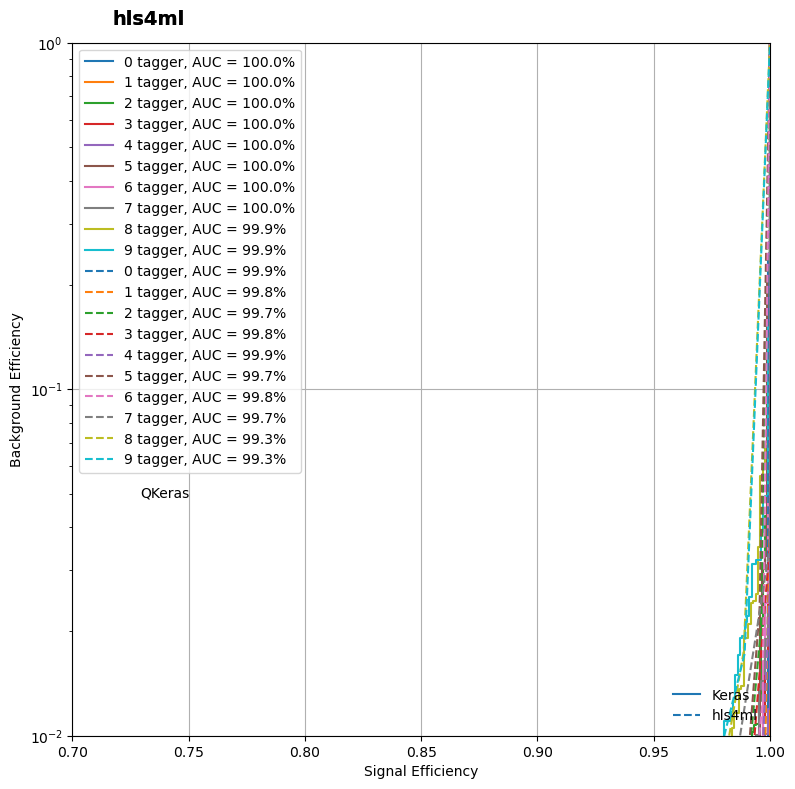

In [52]:
import utils.plotting as plotting
from sklearn.metrics import accuracy_score


def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    accuracy_keras = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred, axis=1)))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred_hls4ml, axis=1)))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))

    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred, labels=['%i' % nr for nr in range(n_classes)])
    plt.gca().set_prop_cycle(None)  # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, labels=['%i' % nr for nr in range(n_classes)], linestyle='--')

    from matplotlib.lines import Line2D

    lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend

    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'], loc='lower right', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.38, label, wrap=True, horizontalalignment='left', verticalalignment='center')
    plt.ylim(0.01, 1.0)
    plt.xlim(0.7, 1.0)


# Plot the pruned floating point model:
plotROC(y_test, y_predict, y_predict_hls4ml, label="Keras")

# Plot the pruned and quantized QKeras model
plotROC(y_test, y_predict_q, y_predict_hls4ml_q, label="QKeras")

In [53]:
from template_injector import TemplateInjector

injector = TemplateInjector(template_dir="templates")

injector.inject(
    project_dir="Projects/Baseline",
    project_name="baseline_cnn",
    force=True  # or False to skip existing files
)

injector.inject(
    project_dir="Projects/Quantized",
    project_name="quantized_cnn",
    force=True  # or False to skip existing files
)


✅ Injected: Projects/Baseline/firmware/baseline_cnn_stream.cpp
✅ Injected: Projects/Baseline/firmware/baseline_cnn_stream.h
✅ Injected: Projects/Baseline/baseline_cnn_test.cpp
📁 Copied: build_tb.py → Projects/Baseline/build_tb.py
📁 Copied: compute_performance.py → Projects/Baseline/compute_performance.py
📁 Copied: build_prj.tcl → Projects/Baseline/build_prj.tcl
📁 Copied: golden_preds.py → Projects/Baseline/golden_preds.py
✅ Injected: Projects/Quantized/firmware/quantized_cnn_stream.cpp
✅ Injected: Projects/Quantized/firmware/quantized_cnn_stream.h
✅ Injected: Projects/Quantized/quantized_cnn_test.cpp
📁 Copied: build_tb.py → Projects/Quantized/build_tb.py
📁 Copied: compute_performance.py → Projects/Quantized/compute_performance.py
📁 Copied: build_prj.tcl → Projects/Quantized/build_prj.tcl
📁 Copied: golden_preds.py → Projects/Quantized/golden_preds.py


In [2]:
import os
pwd = os.getcwd()
print(f"Current working directory: {pwd}")
build = True  # Set to True if you want to build the project, False to skip

Current working directory: /home/theodoros/Projects/AI_ON_FPGA


In [55]:
if build:
    os.system(f"cd {pwd}/Projects/Baseline/ && python build_tb.py && vitis-run --mode hls --tcl build_prj.tcl && python compute_performance.py && python golden_preds.py")

2025-08-08 19:19:36.028909: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 19:19:36.030138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 19:19:36.050741: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 19:19:36.050769: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 19:19:36.050792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

✅ Quantized data written to 'tb_data/tb_input_features.dat' and 'tb_data/tb_output_predictions.dat'

****** vitis-run v2024.2 (64-bit)
  **** SW Build 5239630 on 2024-11-10-11:19:46
  **** Start of session at: Fri Aug  8 19:19:42 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

  **** HLS Build v2024.2 5238294
Sourcing Tcl script '/home/theodoros/Projects/AI_ON_FPGA/Projects/Baseline/build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project -reset baseline_cnn_prj 
INFO: [HLS 200-10] Creating and opening project '/home/theodoros/Projects/AI_ON_FPGA/Projects/Baseline/baseline_cnn_prj'.
INFO: [HLS 200-1510] Running: set_top baseline_cnn_stream 
INFO: [HLS 200-1510] Running: add_files firmware/baseline_cnn_stream.cpp -cflags -std=c++14 
INFO: [HLS 200-10] Adding design file 'firmware/baseline_cnn_stream.cpp' to the project
INFO: [HLS 200-1510] Running: add_files firmware/baseline_cnn.cpp -cflags

2025-08-08 19:47:39.731795: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 19:47:39.733866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 19:47:39.760504: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 19:47:39.760525: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 19:47:39.760568: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

313/313 [==============================] - 1s 2ms/step
Saved all 10,000 quantized inputs to 'golden_inputs.npy' and predictions to 'golden_preds.npy'


In [3]:
if build:
    os.system(f"cd {pwd}/Projects/Quantized/ && python build_tb.py && vitis-run --mode hls --tcl build_prj.tcl && python compute_performance.py && python golden_preds.py")

2025-08-08 19:57:46.029281: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 19:57:46.031802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 19:57:46.057914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 19:57:46.057937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 19:57:46.057985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

✅ Quantized data written to 'tb_data/tb_input_features.dat' and 'tb_data/tb_output_predictions.dat'

****** vitis-run v2024.2 (64-bit)
  **** SW Build 5239630 on 2024-11-10-11:19:46
  **** Start of session at: Fri Aug  8 19:57:49 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

  **** HLS Build v2024.2 5238294
Sourcing Tcl script '/home/theodoros/Projects/AI_ON_FPGA/Projects/Quantized/build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project -reset quantized_cnn_prj 
INFO: [HLS 200-10] Opening and resetting project '/home/theodoros/Projects/AI_ON_FPGA/Projects/Quantized/quantized_cnn_prj'.
INFO: [HLS 200-1510] Running: set_top quantized_cnn_stream 
INFO: [HLS 200-1510] Running: add_files firmware/quantized_cnn_stream.cpp -cflags -std=c++14 
INFO: [HLS 200-10] Adding design file 'firmware/quantized_cnn_stream.cpp' to the project
INFO: [HLS 200-1510] Running: add_files firmware/quantized_cnn.cp

2025-08-08 20:30:22.579374: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 20:30:22.587591: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-08 20:30:22.717609: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 20:30:22.717648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 20:30:22.718088: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

313/313 [==============================] - 1s 3ms/step
Saved all 10,000 quantized inputs to 'golden_inputs.npy' and predictions to 'golden_preds.npy'
